In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import haversine_distances

In order to avoid crashing the kernel, only read a portion of the data

In [5]:
df = pd.read_csv('train.csv', nrows = 1_000_000)
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In order to determine the amount of distance traveled, use the Haversine formula

Note, I didn't use Euclidean distance because the coordinates are points on a sphere. 

In [6]:
def hav_distance(lon1, lat1, lon2, lat2):
    # use sklearn's haversine function and multiply by Earth's radius to get distance in km
    return haversine_distances([[lon1, lat1], [lon2, lat2]])[0][1] * 6371000/1000

# create new feature using this function, distance in km
df['distance_traveled_km'] = df.apply(lambda x: hav_distance(x['pickup_longitude'], x['pickup_latitude'], 
                                                             x['dropoff_longitude'], x['dropoff_latitude']), axis=1)

To clean the data, drop any NaNs from the df

In [7]:
df = df.dropna(axis='rows')
print('New number of observations: %d' % len(df))

New number of observations: 999990


Find distribution of the distance traveled

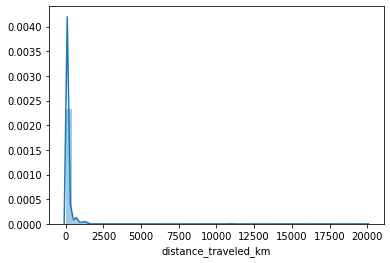

In [8]:
sns.distplot(df['distance_traveled_km'])

In [9]:
df['distance_traveled_km'].quantile(.95)

621.2290233476851

Some of the observations are too high to make sense, so take out all of the rows where the distance traveled is above the 95th percentile, then also take out all of the rows where the distances is 0

In [10]:
df = df[df['distance_traveled_km'] <= df['distance_traveled_km'].quantile(.95)]
df = df[df['distance_traveled_km'] > 0]
df['distance_traveled_km'].describe()

count    921504.000000
mean        107.724525
std          96.291255
min           0.000214
25%          42.439587
50%          80.011456
75%         141.368595
max         621.220036
Name: distance_traveled_km, dtype: float64

New distribution after the filtering

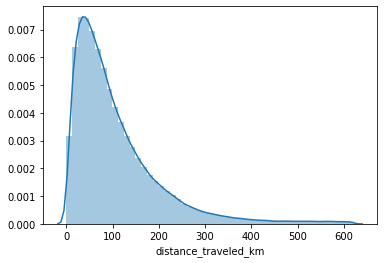

In [11]:
sns.distplot(df['distance_traveled_km'])

Some of the fares also make no sense, so fix that too.

Since as of 2018, the lowest base fee for a taxi ride in NYC is $2.50, I'll drop observations with fare_amount below 1.5

In [12]:
df = df[df['fare_amount'] > 1.5]

In [13]:
df['fare_amount'].quantile(.999)

57.33

If the 99.9th percentile is less than 58, it looks safe to just cut out values >= 60

In [14]:
df = df[df['fare_amount'] < 60]
df['fare_amount'].describe()

count    920744.000000
mean          9.757954
std           5.886955
min           2.500000
25%           6.000000
50%           8.100000
75%          11.700000
max          59.830000
Name: fare_amount, dtype: float64

Text(0.5, 1.0, 'Histogram')

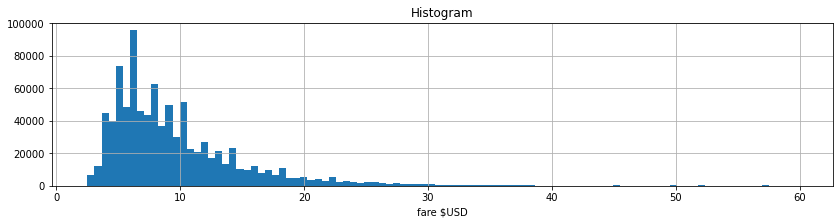

In [15]:
df.fare_amount.hist(bins=100, figsize=(14,3))
plt.xlabel('fare $USD')
plt.title('Histogram')

Then cut out all of the rows where the passenger count is zero

In [16]:
df = df[df['passenger_count'] > 0]

In [17]:
df[['pickup_latitude', 'pickup_longitude']].describe()

,pickup_latitude,pickup_longitude
count,917330.000000,917330.000000
mean,40.694324,-73.916658
std,2.706547,2.633202
min,-74.016587,-121.391210
25%,40.737075,-73.992561
50%,40.753385,-73.982383
75%,40.767190,-73.969800
max,424.083332,40.812887


Clearly some of longitudes and latitudes do not make sense. 40 degrees lattitude is well into NJ,
so any rows with < 40 latitude should be dropped. Similarly anything > 42 degrees lattitude is very north of NYC and should also be dropped

As for longitude, anything above -72 degrees is east of Long Island and should be dropped. Anything below -75 is far west of NYC and should also be cut

In [18]:
# cut rows with latitude <= 40
df = df[df['pickup_latitude'] > 40]

# cut rows with latitude >= 42
df = df[df['pickup_latitude'] < 42]

# cut rows with longitude >= -72
df = df[df['pickup_longitude'] < -72]

# cut rows with longitude <= -75
df = df[df['pickup_longitude'] > -75]

df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_traveled_km
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,17.231137
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,246.295936
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,55.251875
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,38.152003
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,74.122374


I think the time of day may be relevant to the fares, so I'll create a new feature called time of day that will have the hour of the day extracted from the datetime stamp

Create a feature for the day of the week

Basically what I'm thinking at this point is to first figure out what other values don't make sense and take them out of the data. Then I want to convert the pickup_datetime into a useable timestamp. Finally, I think it could be helpful to build a multiple linear regression using the distance_traveled, passenger_count, and time of day based on the time stamp

I want to parse the pickup datetime to get the time of day that each ride occurs, creating a feature called time_of_day

In [20]:
# function to parse datetime stamp and extract hour of the day
def time_parse(time_str):
    time = time_str.split()[1]
    return int(time.split(":")[0])

df['pickup_hour'] = df.apply(lambda x: time_parse(x['pickup_datetime']), axis=1)

Then, try fitting multiple linear regression model to training data, then test with test.csv

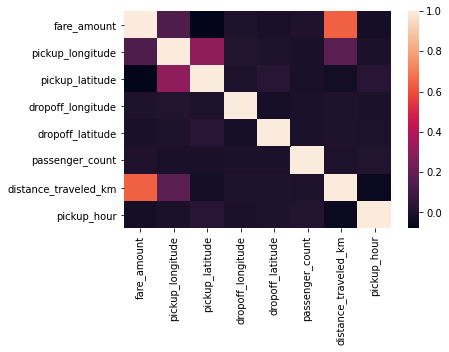

In [29]:
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

Text(0.5, 1.0, 'Pickup Hour Distribution')

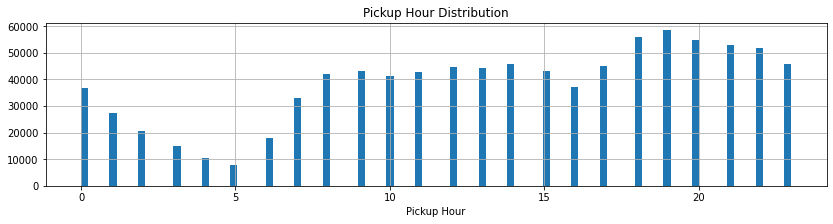

In [32]:
df.pickup_hour.hist(bins=100, figsize=(14,3))
plt.xlabel('Pickup Hour')
plt.title('Pickup Hour Distribution')

Next figure out the average fare for each hour

In [41]:
means = df.groupby('pickup_hour')['fare_amount'].mean()
means

pickup_hour
0     10.645764
1     10.617459
2     10.684989
3     10.996552
4     11.245043
5     10.552074
6      9.095901
7      9.132586
8      9.492579
9      9.507556
10     9.398372
11     9.497832
12     9.517612
13     9.559249
14     9.597877
15     9.594305
16     9.426025
17     9.611208
18     9.627188
19     9.445463
20     9.585508
21     9.860345
22    10.184498
23    10.418996
Name: fare_amount, dtype: float64

There doesn't seem to be a huge difference between the different averages based on time of day